# Beamforming of the 2023-09-16 92s VLP event

This notebook was used to estimate the location of the 2023-09-16 92s VLP event using beamforming.

Before you this notebook make sure to first download (`download.py`) and pre-process (`prep.py`) the seismograms. For ray-traced traveltimes in the LITHO1 model, run `fmm.py` and `fmm_merge.py` also.

The notebook follows these steps:

1. define parameters
2. load waveforms & station coordinates
3. data quality check
4. beamforming
4. visualisation (Fig. SXX and Movie SXX in the manuscript)

Requirements:
- Python
- Scientific Python stack (numpy, matplotlib, ...)
- pytorch (for fast matrix operations)
- obspy (for reading seismic data)
- tqdm (for progressbars)
- cartopy (for maps)
- geokernels (for distances on Earth)
- cmcrameri (for colormaps)

In [12]:
from itertools import product
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import torch
from cmcrameri import cm
from geokernels.distance import geodist
from obspy import Inventory, read_inventory, read, UTCDateTime
from scipy.signal import iirfilter, zpk2sos, sosfiltfilt
from tqdm import tqdm

## 0 - parameters

In [13]:
# -- general parameters
# contains preprocessed waveforms (output of prep.py)
waveform_dir = "waveforms_prep/"
# contains station metadata (output of download.py)
station_dir = "stations/"

# -- data selection parameters
# a reference location to be able to limit stations to a certain distance
# approximate location of landslide.
loc_reference = -26.9621, 72.8087
# maximum allowed distance
max_distance_km = 20_000
# select stations with best coherency with other stations
# given as a percentile of the coherency distribution
# 25% worst stations are discarded
coherency_percentile = 33

# -- beamforming parameters

# the spatial grid to beamform on
grid_lim_lon = -38, -14
grid_lim_lat = 68.5, 77
grid_spacing_lon = 0.1
grid_spacing_lat = 0.1

# velocity parameters
# mode can be "gridsearch" or "fmm"
# vel_mode = "fmm"
vel_mode = "fmm"
# if mode is "gridsearch", the velocity grid to search on
vel_min, vel_max = 3.5, 4.5
vel_min, vel_max = 4.0, 4.2
vel_spacing = 0.01
# if mode is "fmm" instead, use pre-computed travel times
# file is generated by fmm.py and fmm_merge.py
# must use same grid as defined above
tt_file = "fmm_traveltimes.npy"

# - beamforming time windows
# the start of the first beamforming window
global_starttime = UTCDateTime("2023-09-16T12:00:00.0Z")
# end before this time for the last beamforming window
# global_endtime = UTCDateTime("2023-09-17T06:00:00.0Z")
# global_endtime = UTCDateTime("2023-09-26T01:00:00.0Z")
global_endtime = UTCDateTime("2023-09-17T01:00:00.0Z")
# the length of the beamforming window in seconds
window_length = 2 * 3600
# the overlap between two consecutive windows in percent
# window_overlap_percentage = 0.75
window_overlap_percentage = 0
# filtering can introduce filter artefacts at the edges of the window
# therefore, we add a buffer to the window on both sides
buffer_length = 1800

# - frequency
# sampling_rate of the seismograms in {waveform_dir}
# if you used download.py and prep.py, this should be 0.1 (VHZ)
sampling_rate = 0.1
# frequency band to use for beamforming (Hz)
fmin, fmax = 10e-3, 12e-3

## 1 - load waveforms & station coordinates

In [14]:
# list of stations for which prepped waveforms are available
stations_prepped = [
    x.name.removesuffix(".mseed") for x in Path(waveform_dir).glob("*.mseed")
]

# parse inventory for only those
inv = read_inventory(f"{station_dir}/*")
prepped_inv = Inventory()
for sta in sorted(stations_prepped):
    prepped_inv += inv.select(
        network=f"{sta.split('.')[0]}",
        station=f"{sta.split('.')[1]}",
    )

# extract array coordinates, and remember order of coordinates
coordinates = []
coordinates_stations = []
for net in prepped_inv:
    for sta in net:
        # skip duplicates
        if f"{net.code}.{sta.code}" in coordinates_stations:
            continue
        coordinates.append([sta.longitude, sta.latitude])
        coordinates_stations.append(f"{net.code}.{sta.code}")
coordinates = torch.tensor(np.array(coordinates))

print(f"coordinates available for {len(coordinates)} stations")

# starttimes of beamforming windows
starttimes = np.arange(
    global_starttime,
    global_endtime - window_length,
    window_length * (1 - window_overlap_percentage),
)

# the window length including buffer (to avoid filter artefacts)
# later on, waveforms will be cut to window_length length
expected_window_length = int((window_length + 2 * buffer_length) * sampling_rate + 1)

# make sure to load data in order of coordinates_stations
waveforms = torch.zeros(
    (len(starttimes), len(coordinates_stations), expected_window_length)
)
used_coords = []
for sta_idx, sta in tqdm(
    enumerate(coordinates_stations),
    total=len(coordinates_stations),
    desc="loading waveforms",
):
    st = read(f"{waveform_dir}/{sta}.mseed")
    # should not fail, because prep.py produces single-trace seismograms for each station
    tr = st.select(channel="*Z")[0]

    for starttime_idx, starttime in enumerate(starttimes):
        trimtime_start = starttime - buffer_length
        trimtime_end = starttime + window_length + buffer_length
        tr_current = tr.slice(
            starttime=trimtime_start,
            endtime=trimtime_end,
        )

        waveforms[starttime_idx, sta_idx, :] = torch.tensor(tr_current.data)

print(
    f"waveforms loaded for {waveforms.shape[1]} stations in {waveforms.shape[0]} time windows"
)

coordinates available for 1488 stations


loading waveforms: 100%|██████████| 1488/1488 [00:34<00:00, 42.61it/s] 

waveforms loaded for 1488 stations in 6 time windows


## 2 - data quality

In [15]:
# -- step 2.1 - normalise waveform amplitudes in selected frequency band

# define filter
fn = 0.5 * sampling_rate
low = fmin / fn
high = fmax / fn
z, p, k = iirfilter(4, [low, high], btype="band", ftype="butter", output="zpk")
sos = zpk2sos(z, p, k)

# taper before filtering
p = 0.05
taper_len = int(waveforms.shape[-1] * p)
hann_window = torch.hann_window(2 * taper_len)
taper = torch.ones(waveforms.shape[-1])
taper[:taper_len] = hann_window[:taper_len]
taper[-taper_len:] = hann_window[-taper_len:]
waveforms_taper = waveforms * taper[None, :]

# filter
waveforms_filt = sosfiltfilt(sos, waveforms_taper, axis=2)
waveforms_filt = torch.tensor(waveforms_filt.copy())

# cut to actually used time window
# by removing buffer
waveforms_filt = waveforms_filt[
    :, :, int(buffer_length * sampling_rate) : -int(buffer_length * sampling_rate)
]

# compute time and frequency axes from final window length
times = torch.arange(waveforms_filt.shape[-1]) / sampling_rate
freqs = torch.fft.fftfreq(len(times), 1 / sampling_rate)
omega = 2 * torch.pi * freqs
freq_idx = torch.where((freqs > fmin) & (freqs < fmax))[0]

# taper again for cleaner waveforms
p = 0.02
taper_len = int(waveforms_filt.shape[-1] * p)
hann_window = torch.hann_window(2 * taper_len)
taper = torch.ones(waveforms_filt.shape[-1])
taper[:taper_len] = hann_window[:taper_len]
taper[-taper_len:] = hann_window[-taper_len:]
waveforms_filt_taper = waveforms_filt

# normalise filtered, tapered waveforms
waveforms_filt_taper /= waveforms_filt_taper.max(dim=-1, keepdim=True)[0]

# copy before selection
coordinates_sel = coordinates.detach().clone()
waveforms_sel = waveforms_filt_taper.detach().clone()

print(f"{len(coordinates_sel)} stations before selection")

# -- step 2.2 - select stations by distance

# compute distances to reference location
source = torch.tensor(loc_reference)
source_e = source.flip(0).repeat(coordinates_sel.shape[0], 1)
distances_ctbto = geodist(coordinates_sel.flip(1), source_e, metric="km")
distances_ctbto = torch.tensor(distances_ctbto).T

# select by distance
distance_select_idxs = np.where(distances_ctbto <= max_distance_km)[0]
waveforms_sel = waveforms_sel[:, distance_select_idxs]
coordinates_sel = coordinates_sel[distance_select_idxs]

print(f"{len(coordinates_sel)} stations after distance selection")

# -- step 2.3 - select stations by coherency

# compute spectra and move to dask
# further computations can be easily memory-limited for broad frequency bands
wf_fft = torch.fft.fft(waveforms_sel, dim=-1)[:, :, freq_idx.numpy()]
wf_fft_da = da.from_array(wf_fft.numpy(), chunks=(1, 100, -1))

covariance = wf_fft_da[:, :, None, :] * wf_fft_da.conj()[:, None, :, :]
correlations = da.fft.ifft(covariance, axis=-1).real
correlations_peak = da.max(correlations, axis=-1)
correlations_peak = torch.tensor(correlations_peak.compute())

# estimate average coherency for each station with all other stations
# and across all time windows
avg_coherency = torch.mean(correlations_peak, dim=[1, 0])
coherency_threshold = np.percentile(avg_coherency, coherency_percentile)
coherency_idxs = torch.where(avg_coherency < coherency_threshold)[0]

# instead, select randomly
# coherency_idxs = np.random.choice(
#     np.arange(len(coordinates_sel)),
#     int((coherency_percentile / 100) * len(coordinates_sel)),
#     replace=False,
# )

# select based on coherency
coherency_mask = np.ones(waveforms_sel.shape[1], dtype=bool)
coherency_mask[coherency_idxs] = False
coordinates_sel = coordinates_sel[coherency_mask]
waveforms_sel = waveforms_sel[:, coherency_mask]

print(f"{len(coordinates_sel)} stations after coherency selection")

1488 stations before selection
1488 stations after distance selection


/home/zmaw/u254070/anaconda3/envs/311/lib/python3.11/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


997 stations after coherency selection


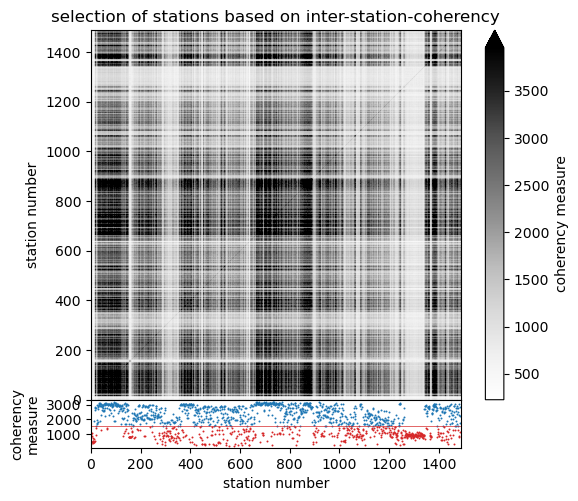

In [16]:
# visualize coherency selection

fig, ax = plt.subplots(1)
pcm = ax.imshow(
    correlations_peak.mean(dim=0),
    cmap="Greys",
    origin="lower",
    vmin=min(avg_coherency),
    vmax=torch.quantile(correlations_peak.mean(dim=0), 0.9),
)

plt.colorbar(pcm, ax=ax, label="coherency measure", extend="max")
ax.set(
    ylabel="station number",
    xticks=[],
    title="selection of stations based on inter-station-coherency",
)
# add separate axis for average coherency (over all windows)
x0, y0, width, height = ax.get_position().bounds
ax2 = fig.add_axes([x0, y0 - 0.1, width, 0.1])
i = np.arange(len(avg_coherency))
ax2.scatter(
    i[avg_coherency > coherency_threshold],
    avg_coherency[avg_coherency > coherency_threshold],
    s=2,
    lw=0,
    c="tab:blue",
)
ax2.scatter(
    i[avg_coherency < coherency_threshold],
    avg_coherency[avg_coherency < coherency_threshold],
    s=2,
    lw=0,
    c="tab:red",
)
ax2.axhline(coherency_threshold, color="tab:red", lw=0.5)
ax2.set(
    xlim=(0, len(avg_coherency)), ylabel="coherency\nmeasure", xlabel="station number"
)
print()

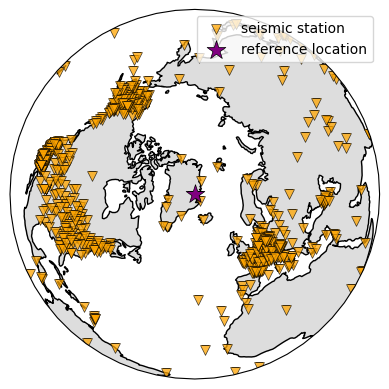

In [17]:
# visualize station distribution after selection

fig, ax = plt.subplots(
    1,
    subplot_kw={
        "projection": ccrs.Orthographic(
            central_longitude=loc_reference[0], central_latitude=loc_reference[1]
        )
    },
)
ax.coastlines()
ax.scatter(
    *coordinates_sel.T,
    transform=ccrs.PlateCarree(),
    marker="v",
    c="orange",
    ec="k",
    s=50,
    lw=0.5,
    alpha=0.75,
    zorder=2,
    label="seismic station",
)

ax.scatter(
    *loc_reference,
    transform=ccrs.PlateCarree(),
    marker="*",
    c="purple",
    ec="k",
    s=200,
    lw=0.5,
    zorder=2,
    label="reference location",
)
ax.add_feature(cfeature.LAND, color="#ddd")

ax.legend(loc=1)
ax.set_global()
# ax.set(title=f"{len(coordinates_sel)} stations after selection")
print()

## 3 - Beamforming

In [18]:
# 3.1 - beamforming prep

# geographic grid
grid_coords_lon = torch.arange(
    grid_lim_lon[0], grid_lim_lon[1] + grid_spacing_lon, grid_spacing_lon
)
grid_coords_lat = torch.arange(
    grid_lim_lat[0], grid_lim_lat[1] + grid_spacing_lat, grid_spacing_lat
)
gridpoints = torch.tensor(list(product(grid_coords_lat, grid_coords_lon)))

# distances on earth using geokernels
# for geodist, both tensors need to have the same shape.
# flip, because geodist expects (lat, lon) instead of (lon, lat),
# gridpoints are already defined that way, no need to flip.
dists = [
    geodist(gridpoints, sta.flip(0).repeat(gridpoints.shape[0], 1), metric="km")
    for sta in coordinates_sel
]
dists = torch.tensor(np.array(dists)).T

# velocities to test
if vel_mode == "gridsearch":
    medium_velocities = torch.arange(vel_min, vel_max + vel_spacing, vel_spacing)
    traveltimes = dists / medium_velocities[:, None, None]
# support for pre-comptued traveltimes
elif vel_mode == "fmm":
    # contains traveltimes for all gridpoints and stations
    # generated by fmm.py
    traveltimes_gridpoints_stations = np.load(tt_file)
    # limit to stations actually used
    traveltimes_gridpoints_stations = traveltimes_gridpoints_stations[
        :, distance_select_idxs
    ]
    traveltimes_gridpoints_stations = traveltimes_gridpoints_stations[:, coherency_mask]

    # expand frequency dimension
    traveltimes = traveltimes_gridpoints_stations[:, :, None].repeat(
        len(freq_idx), axis=-1
    )

# compute spectra of waveforms
waveform_spectra = torch.fft.fft(waveforms_sel, dim=-1)

# limit to frequency band of interest for
# a) significant speed-up
# b) focusing on specific frequencies
omega_lim = omega[freq_idx]
waveform_spectra_lim = waveform_spectra[:, :, freq_idx]

In [19]:
# 3.2 - beamforming

# Cross-correlation beamforming beampower B:
# B = ∑_ω ∑_j ∑_k≠j S_kj(ω) * K_jk(ω)
# with K the cross-spectral density matrix of recordings
# S the cross-spectral density matrix of synthetic signals (replica vectors, Green's functions)
# for station pairs j,k and frequency ω.
# For more details, see:
# Ruigrok, E., Gibbons, S. & Wapenaar, K., 2017. Cross-correlation beamforming. J Seismol, 21, 495–508. doi:10.1007/s10950-016-9612-6
# Schippkus, S. & Hadziioannou, C., 2022. Matched field processing accounting for complex Earth structure: method and review. Geophysical Journal International, 231, 1268–1282. doi:10.1093/gji/ggac240
# Schippkus, S. (2023). schipp/fast_beamforming: 2023-09-04 first release (Version v1). Zenodo. https://doi.org/10.5281/zenodo.8315028

# 3.2.1 - compute K (cross-spectral density matrix of recordings)
K = waveform_spectra_lim[:, :, None, :] * waveform_spectra_lim.conj()[:, None, :, :]

# exclude auto-correlations (j==k), i.e., do "cross-correlation beamforming"
diag_idxs = torch.arange(K.shape[0])
zero_spectra = torch.zeros(omega_lim.shape, dtype=torch.cdouble)
K[:, diag_idxs, diag_idxs, :] = zero_spectra

print(
    f"K has shape (n_windows={K.shape[0]}, n_stations={K.shape[1]}, n_stations={K.shape[2]}, n_freqs={K.shape[3]})"
)

# 3.2.1 - compute S (compute cross-specral density matrix of Green's functions)

# G = exp(-iωt)
if vel_mode == "gridsearch":
    greens_functions = torch.exp(
        -1j * omega_lim[None, None, None, :] * traveltimes[:, :, :, None]
    )
elif vel_mode == "fmm":
    greens_functions = torch.exp(-1j * omega_lim[None, None, None, :] * traveltimes)

# force complexdouble type
# fixes type mismatch that arises from 1j -> cfloat, but fft -> cdouble
greens_functions = greens_functions.type(torch.cdouble)
greens_functions_dask = da.from_array(greens_functions.numpy(), chunks=(1, 100, 100, 1))

S = (
    greens_functions_dask[:, :, :, None, :]
    * greens_functions_dask.conj()[:, :, None, :, :]
)

print(
    f"S has shape (n_velocities={S.shape[0]}, n_gridpoints={S.shape[1]}, n_stations={S.shape[2]}, n_stations={S.shape[3]}, n_freqs={S.shape[4]}))"
)

K = da.from_array(K.numpy())

load_instead_of_compute = False
if load_instead_of_compute:
    beampowers = torch.tensor(np.load("beampowers_fmm_075.npy"))
# beamformer (see above)
else:
    beampowers_d = da.einsum("sxjkw, tkjw -> tsx", S, K).real
    beampowers = torch.tensor(beampowers_d.compute())
print(
    f"Successfully computed beampowers with shape (n_windows={beampowers.shape[0]}, n_velocities={beampowers.shape[1]}, n_gridpoints={beampowers.shape[2]})"
)

K has shape (n_windows=6, n_stations=997, n_stations=997, n_freqs=14)


/home/zmaw/u254070/anaconda3/envs/311/lib/python3.11/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


S has shape (n_velocities=21, n_gridpoints=20726, n_stations=997, n_stations=997, n_freqs=14))


In [ ]:
# save beampowers
# np.save("beampowers_fmm_075.npy", beampowers.numpy())

71.67688272255035
68.26401422556592
94.60738882939255


/home/zmaw/u254070/anaconda3/envs/311/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/tmp/ipykernel_64109/1820788422.py:342: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item, label in zip(leg.legendHandles, leg.texts):


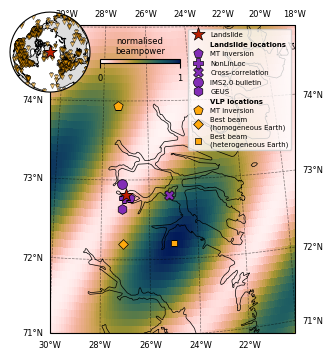

In [ ]:
# visualize beampowers

# beampowers = torch.tensor(np.load("beampowers.npy"))

# plt.style.use("colorblind")

fig, ax = plt.subplots(
    1,
    subplot_kw={
        "projection": ccrs.NearsidePerspective(
            central_latitude=loc_reference[1],
            central_longitude=loc_reference[0],
            satellite_height=100_000,
        )
        # "projection": ccrs.PlateCarree()
    },
    figsize=(4, 4),
)

# for static fig, stack results from first ~12 hours after event
sidx = np.argmin(np.abs(starttimes - UTCDateTime("2023-09-16T12:00:00")))
eidx = np.argmin(np.abs(starttimes - UTCDateTime("2023-09-17T00:00:00")))


# extract dominant best velocity for time windows in time range above
if vel_mode == "gridsearch":
    bp_reshape = beampowers.reshape(
        len(starttimes),
        len(medium_velocities),
        len(grid_coords_lat),
        len(grid_coords_lon),
    )
    if len(medium_velocities) != 1:
        best_velocities = torch.tensor(
            np.array(
                [
                    medium_velocities[torch.where(_ == _.max())[0][0]]
                    for _ in bp_reshape[sidx:eidx]
                ]
            )
        ).unique(return_counts=True)
        best_velocity = best_velocities[0][best_velocities[1].argmax()]
        best_velocity_idx = torch.where(medium_velocities == best_velocity)[0][0]
    else:
        best_velocity = medium_velocities[0]
        best_velocity_idx = 0
elif vel_mode == "fmm":
    bp_reshape = beampowers.reshape(
        len(starttimes),
        1,
        len(grid_coords_lat),
        len(grid_coords_lon),
    )
    best_velocity_idx = 0

if eidx == sidx:
    bp = bp_reshape[sidx, best_velocity_idx].detach().clone()
else:
    bp = bp_reshape[sidx:eidx, best_velocity_idx].detach().clone().mean(dim=0)

bp /= abs(bp).max()

xx, yy = torch.meshgrid(grid_coords_lon, grid_coords_lat, indexing="xy")
pcm = ax.pcolormesh(
    xx,
    yy,
    bp,
    cmap=cm.batlowW_r,
    vmin=0,
    vmax=1,
    transform=ccrs.PlateCarree(),
    edgecolors="face",
    linewidths=0.5,
    # alpha=0.8,
)

ax.coastlines(color="k", lw=0.5, zorder=1)
# ax.add_feature(cfeature.LAND, color="#ddd", alpha=0.2, zorder=1)

from obspy.geodetics import gps2dist_azimuth

# compute distance to reference location
dist, _, _ = gps2dist_azimuth(
    lon1=gridpoints[bp.argmax()].flip(0)[0],
    lat1=gridpoints[bp.argmax()].flip(0)[1],
    lon2=-27.1,
    lat2=72.2,
)
dx_homo = dist / 1000
print(dx_homo)
# dx_homo = geodist(gridpoints[bp.argmax()].flip(0), (-27.1, 72.2), metric="km")

from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6"])

other_locations = {
    "Landslide": (
        -26.9621,
        72.8087,
        {"marker": "*", "color": cmap(2), "s": 100, "zorder": 10},
    ),
    # landslide locations
    "MT inversion ": (
        -26.796,
        72.772,
        {"marker": "p", "color": cmap(4), "s": 50},
    ),
    "NonLinLoc": (-27.05, 72.77, {"marker": "P", "color": cmap(4), "s": 50}),
    "Cross-correlation": (
        -25.1739,
        72.806,
        {"marker": "X", "color": cmap(4), "s": 50},
    ),
    "IMS2.0 bulletin": (
        -27.1475,
        72.9534,
        {"marker": "o", "color": cmap(4), "s": 50},
    ),
    "GEUS": (
        -27.151,
        72.644,
        {"marker": "h", "color": cmap(4), "s": 50},
    ),
    # VLP locations
    "MT inversion": (
        -27.345,
        73.929,
        {"marker": "p", "color": cmap(1), "s": 50},
    ),
    # f"Best beam\n($\Delta$ x = {dx_homo:.1f} km)\n(homogeneous Earth)": (
    f"Best beam\n(homogeneous Earth)": (
        -27.1,
        72.2,
        {"marker": "D", "color": cmap(1), "s": 25},
    ),
}


# compute distance to reference location
# dx = geodist(
#     gridpoints[bp.argmax()].flip(0), other_locations["Landslide"][:2], metric="km"
# )

# distance between best beams
dist, _, _ = gps2dist_azimuth(
    lon1=-25.1,
    lat1=72.2,
    lon2=-27.1,
    lat2=72.2,
)
print(dist / 1000)

dist, _, _ = gps2dist_azimuth(
    lon1=gridpoints[bp.argmax()].flip(0)[0],
    lat1=gridpoints[bp.argmax()].flip(0)[1],
    lon2=other_locations["Landslide"][0],
    lat2=other_locations["Landslide"][1],
)
dx = dist / 1000
print(dx)

a, b = gridpoints[bp.argmax()].flip(0)
loc_beam = float(a), float(b)
ax.scatter(
    *loc_beam,
    marker="s",
    ec="k",
    lw=0.5,
    c=cmap(1),
    s=25,
    # label=f"Best beam at {loc_beam[0]:.1f}, {loc_beam[1]:.1f}",
    # label=f"Best beam ($\Delta x=${dx:.1f} km)\n(heterogeneous Earth)",
    label=f"Best beam\n(heterogeneous Earth)",
    transform=ccrs.PlateCarree(),
    alpha=1,
    zorder=10,
)

for name, (lon, lat, kwargs) in other_locations.items():
    ax.scatter(
        lon,
        lat,
        ec="k",
        lw=0.5,
        transform=ccrs.PlateCarree(),
        label=name,
        alpha=1,
        **kwargs,
    )

    if name == "Landslide":
        ax.scatter([], [], s=0, c=None, label="Landslide locations")
    if name == "IMS2.0 bulletin":
        ax.scatter([], [], s=0, c=None, label="VLP locations")

# plot_extent = (*grid_lim_lon, *grid_lim_lat)
# ax.set_extent([-35, -17, 69, 76])
ax.set_extent([-30, -20, 71, 75])
gl = ax.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
    linewidth=0.5,
    color="k",
    alpha=0.5,
    linestyle="--",
)
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

# inset axis
do_inset = False
if do_inset:
    axins = ax.inset_axes(
        [0.05, 0, 0.4, 0.4],
        transform=ax.transAxes,
        projection=ccrs.NearsidePerspective(
            central_latitude=loc_reference[1],
            central_longitude=loc_reference[0],
            satellite_height=100_000,
        ),
    )
    axins.set_extent([-28, -25, 72.4, 73.2])
    axins.pcolormesh(
        xx, yy, bp, cmap=cm.batlowW_r, vmin=0, vmax=1, transform=ccrs.PlateCarree()
    )
    axins.coastlines(color="k", lw=0.5)

    for name, (lon, lat, kwargs) in other_locations.items():
        axins.scatter(
            lon,
            lat,
            ec="k",
            lw=0.5,
            transform=ccrs.PlateCarree(),
            label=name,
            zorder=3,
            **kwargs,
        )

    ax.indicate_inset_zoom(axins, edgecolor="k", linewidth=1)

x0, y0, w, h = ax.get_position().bounds
ax_stations = fig.add_axes(
    [x0 - 0.1, y0 + w - 0.01, 0.2, 0.2],
    projection=ccrs.Orthographic(
        central_longitude=loc_reference[0], central_latitude=loc_reference[1]
    ),
)

ax_stations.coastlines(lw=0.5)
ax_stations.scatter(
    *coordinates_sel.T,
    transform=ccrs.PlateCarree(),
    marker="v",
    c="orange",
    ec="k",
    s=10,
    lw=0.5,
    alpha=0.5,
    zorder=2,
    label="seismic station",
)

ax_stations.scatter(
    other_locations["Landslide"][0],
    other_locations["Landslide"][1],
    transform=ccrs.PlateCarree(),
    ec="k",
    lw=0.5,
    **other_locations["Landslide"][2],
)

ax_stations.add_feature(cfeature.LAND, color="#ddd")
ax_stations.set_global()

# mark inset axis cartopy

# cax = fig.add_axes([0.35, 0.82, 0.2, 0.01])
# cbar = fig.colorbar(
#     pcm, cax=cax, orientation="horizontal", label="normalised beampower"
# )
# cax.xaxis.set_label_position("top")
# # smaller fontsize of label
# cax.xaxis.label.set_size(8)
# cax.tick_params(labelsize=8)

# cax = fig.add_axes([x0 + 0.0175, y0 + 0.125, 0.175, 0.01])
cax = fig.add_axes([x0 + 0.125, y0 + 0.675, 0.2, 0.01])
# cax = fig.add_axes([x0 + 0.425, y0 + 0.45, 0.175, 0.01])
cbar = fig.colorbar(
    pcm, cax=cax, orientation="horizontal", label="normalised\nbeampower"
)
# smaller fontsize of label
cax.xaxis.set_label_position("top")
cax.xaxis.label.set_size(6)
# set ticks
cax.set_xticks([0, 1])
cax.tick_params(labelsize=6)


# custom legend from scratch
from matplotlib.lines import Line2D

order_of_legend = [
    "Landslide",
    "Landslide locations",
    "MT inversion ",
    "NonLinLoc",
    "Cross-correlation",
    "IMS2.0 bulletin",
    "GEUS",
    "VLP locations",
    "MT inversion",
    "Best beam\n(homogeneous Earth)",
    "Best beam\n(heterogeneous Earth)",
]


def reorderLegend(ax=None, order=None):
    handles, labels = ax.get_legend_handles_labels()
    info = dict(zip(labels, handles))

    new_handles = [info[l] for l in order]
    return new_handles, order


handles, labels = reorderLegend(ax=ax, order=order_of_legend)
leg = ax.legend(
    handles,
    labels,
    loc="upper right",
    frameon=True,
    fontsize=5,
    # title="final list/names tbd",
    # title_fontsize=8,
)

# Move titles to the left
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in ["Landslide locations", "VLP locations"]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-2 * width, 0))
        # label.set_fontsize(6)
        label.set_fontweight("bold")


# handles = []
# for label in order_of_legend:
#     if label in ["Landslide locations", "VLP locations"]:
#         handle = Line2D([], [], color="none", label=label)
#     elif "heterogeneous" in label:
#         handle = Line2D(
#             [0],
#             [0],
#             marker="s",
#             ms="50",
#             color=cmap(1),
#             lw=0,
#         )
#     else:
#         handle = Line2D(
#             [0],
#             [0],
#             marker=other_locations[label][2]["marker"],
#             ms=other_locations[label][2]["s"],
#             color=other_locations[label][2]["color"],
#             lw=0,
#         )
#     handles.append(handle)

# ax.legend(handles, order_of_legend)

# print(loc_beam)

# ax.set_global()
fig.savefig("figS_beamforming.pdf", bbox_inches="tight", dpi=300)
# fig.savefig("beamforming_80deg.png", bbox_inches="tight", dpi=300)

print(loc_beam, best_velocity)

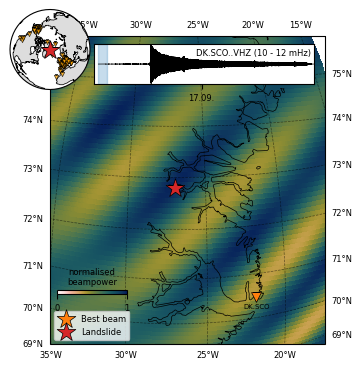

In [ ]:
# animation of beamforming in windows
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(
    1,
    subplot_kw={
        "projection": ccrs.NearsidePerspective(
            central_latitude=loc_reference[1],
            central_longitude=loc_reference[0],
            satellite_height=100_000,
        )
        # "projection": ccrs.PlateCarree()
    },
    figsize=(4, 4),
)

if vel_mode == "gridsearch":
    bp_all_windows = beampowers.reshape(
        len(starttimes),
        len(medium_velocities),
        len(grid_coords_lat),
        len(grid_coords_lon),
    )
elif vel_mode == "fmm":
    bp_all_windows = beampowers.reshape(
        len(starttimes),
        1,
        len(grid_coords_lat),
        len(grid_coords_lon),
    )

from matplotlib.colors import LogNorm

xx, yy = torch.meshgrid(grid_coords_lon, grid_coords_lat, indexing="xy")
pcm = ax.pcolormesh(
    xx,
    yy,
    bp,
    cmap=cm.batlowW_r,
    vmin=0,
    vmax=1,
    transform=ccrs.PlateCarree(),
    edgecolors="face",
    # lognorm
    # norm=LogNorm(vmin=1e5, vmax=bp_all_windows.max()),
)

ax.coastlines(color="k", lw=0.5)

a, b = gridpoints[bp.argmax()].flip(0)
loc_beam = float(a), float(b)
sct_peak = ax.scatter(
    *loc_beam,
    marker="*",
    ec="k",
    lw=0.5,
    c="tab:orange",
    s=200,
    # label=f"Best beam at {loc_beam[0]:.1f}, {loc_beam[1]:.1f}",
    label=f"Best beam",
    transform=ccrs.PlateCarree(),
    zorder=10,
)

for name, (lon, lat, kwargs) in other_locations.items():
    if "beam" in name:
        continue
    ax.scatter(
        lon,
        lat,
        marker="*",
        ec="k",
        lw=0.5,
        transform=ccrs.PlateCarree(),
        label=name,
        zorder=3,
        **kwargs,
    )

ax.legend(
    loc="lower left",
    frameon=True,
    fontsize=6,
)

ax.set_extent([-35, -17, 69, 76])
gl = ax.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
    linewidth=0.5,
    color="k",
    alpha=0.5,
    linestyle="--",
)
# fontsize of grid ticks
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}
# ax.tick_params(labelsize=6)

# mark DK.SCO on map
DK_SCO = -21.95, 70.4833
ax.scatter(
    *DK_SCO,
    marker="v",
    ec="k",
    lw=0.5,
    c="tab:orange",
    s=50,
    transform=ccrs.PlateCarree(),
    zorder=10,
)

# annotate station
# from matplotlib import patheffects

# a_dksco = ax.annotate(
#     "DK.SCO",
#     xy=DK_SCO,
#     xytext=(DK_SCO[0] + 1.5, DK_SCO[1] - 0.75),
#     fontsize=5,
#     ha="left",
#     va="center",
#     zorder=10,
#     arrowprops=dict(arrowstyle="simple", color="#000", lw=0.1),
#     transform=ccrs.PlateCarree(),
#     # path_effects=[patheffects.withStroke(linewidth=1, foreground="w")],
# )

# a_dksco.set_fontproperties(
#     path_effects=[patheffects.withStroke(linewidth=1, foreground="w")],
# )

t_dksco = ax.text(
    DK_SCO[0],
    DK_SCO[1] - 0.15,
    "DK.SCO",
    transform=ccrs.PlateCarree(),
    fontsize=5,
    ha="center",
    va="top",
    zorder=10,
)
# give it outline


# give text of annonation outline
# a_dksco.text.

x0, y0, w, h = ax.get_position().bounds

# cax = fig.add_axes([0.35, 0.82, 0.2, 0.01])
# cax = fig.add_axes([x0 + 0.075, y0 + 0.075, 0.2, 0.01])
# vertical colorbar
# cax = fig.add_axes([x0 + 0.05, y0 + 0.4 * h, 0.01, 0.2 * h])
# horizontal colorbar
cax = fig.add_axes([x0 + 0.0175, y0 + 0.125, 0.175, 0.01])
cbar = fig.colorbar(
    pcm, cax=cax, orientation="horizontal", label="normalised\nbeampower"
)
# smaller fontsize of label
cax.xaxis.set_label_position("top")
cax.xaxis.label.set_size(6)
# set ticks
cax.set_xticks([0, 1])
cax.tick_params(labelsize=6)


# add axes for waveform inside
# ax2 = fig.add_axes([x0 + 0.1 * w, y0 + h * 0.05, 0.8 * w, 0.1])
# have ax at top instead
ax2 = fig.add_axes([x0 + 0.16 * w, y0 + h - 0.12, 0.8 * w, 0.1])


# get a reference waveform of close station
st_ref = read(f"waveforms_prep/DK.SCO.mseed")
st_ref.merge(fill_value="interpolate")
st_ref = st_ref.select(channel="*Z")
st_ref.trim(starttime=global_starttime, endtime=global_endtime)
st_ref.filter("bandpass", corners=4, freqmin=fmin, freqmax=fmax, zerophase=True)
st_ref.taper(0.05)
waveform_reference = st_ref[0].data
waveform_reference /= abs(waveform_reference).max()
times_ref = st_ref[0].times("matplotlib")
starttimes_plt = [s.matplotlib_date for s in starttimes]
endtimes_plt = [(s + window_length).matplotlib_date for s in starttimes]

# plot time windows as moving box
from matplotlib.patches import Rectangle

box = Rectangle(
    (starttimes_plt[0], -1),
    endtimes_plt[0] - starttimes_plt[0],
    2,
    linewidth=1,
    edgecolor="tab:blue",
    facecolor="tab:blue",
    alpha=0.25,
)
ax2.add_patch(box)

ax2.plot(
    times_ref,
    waveform_reference,
    lw=0.5,
    c="k",
    label=f"DK.SCO..VHZ ({fmin*1000:.0f}mHz - {fmax*1000:.0f}mHz)",
)

from matplotlib.dates import DateFormatter, DayLocator

date_formatter = DateFormatter("%d.%m.")
ax2.xaxis.set_major_locator(DayLocator(interval=2))
ax2.xaxis.set_major_formatter(date_formatter)
# fontsize
ax2.tick_params(labelsize=6)

ax2.set_ylim(-1, 1)
ax2.set_xlim(UTCDateTime("2023-09-16T00:00:00.0Z").matplotlib_date, times_ref[-1])
ax2.set_yticks([])

# ax2.legend(loc=1, frameon=False, fontsize=6)
# text in top right
ax2.text(
    0.99,
    0.9,
    "DK.SCO..VHZ (10 - 12 mHz)",
    transform=ax2.transAxes,
    fontsize=6,
    ha="right",
    va="top",
    zorder=10,
)

ax_stations = fig.add_axes(
    [x0 - 0.1, y0 + w - 0.05, 0.2, 0.2],
    projection=ccrs.Orthographic(
        central_longitude=loc_reference[0], central_latitude=loc_reference[1]
    ),
)

ax_stations.coastlines(lw=0.5)
ax_stations.scatter(
    *coordinates_sel.T,
    transform=ccrs.PlateCarree(),
    marker="v",
    c="orange",
    ec="k",
    s=10,
    lw=0.5,
    alpha=0.75,
    zorder=2,
    label="seismic station",
)

ax_stations.scatter(
    other_locations["Landslide"][0],
    other_locations["Landslide"][1],
    transform=ccrs.PlateCarree(),
    marker="*",
    ec="k",
    lw=0.5,
    zorder=2,
    **other_locations["Landslide"][2],
)

ax_stations.add_feature(cfeature.LAND, color="#ddd")
ax_stations.set_global()


def animate(ix):
    current_bp = bp_all_windows[ix]

    bp = current_bp[best_velocity_idx].detach().clone()
    bp /= abs(bp).max()

    a, b = gridpoints[bp.argmax()].flip(0)
    loc_beam = float(a), float(b)

    pcm.set_array(bp.numpy().ravel())
    sct_peak.set_offsets(np.array([loc_beam]))
    box.set_x(starttimes_plt[ix])
    # line1.set_xdata(starttimes_relative[ix])
    # line2.set_xdata(starttimes_relative[ix] + window_length * sampling_rate)


# M5.5 Indian Ocean event
# event_time = UTCDateTime("2023-09-16T14:40:00.000").matplotlib_date
# ax2.annotate(
#     "M5.5 Indian Ocean",
#     xy=(event_time, 0.3),
#     xytext=(event_time, 0.75),
#     arrowprops=dict(facecolor="black", width=0.5, headwidth=5, headlength=5),
#     horizontalalignment="left",
#     verticalalignment="bottom",
#     fontsize=8,
# )

anim = FuncAnimation(fig, animate, frames=len(starttimes), interval=100)
anim.save("S1_movie.mp4", dpi=200)